In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


In [107]:
train = pd.read_csv(r"data/train.csv")
test = pd.read_csv(r"data/test.csv")
sample_submission = pd.read_csv(r"data/sample_submission.csv")

sample_submission.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


# Handle missing values

In [108]:
# Check for missing values
print("\nMissing values in training set:")
train.isnull().sum()


Missing values in training set:


id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [109]:
def create_preprocessor(numerical_cols, categorical_cols):
    preprocessor = ColumnTransformer(
        transformers=[
            # Impute missing numerical values with median
            ('num', SimpleImputer(strategy='median'), numerical_cols),
            
            # Impute missing categorical values AND one-hot encode in one step
            ('cat', 
             Pipeline([
                 ('imputer', SimpleImputer(strategy='most_frequent')),
                 ('encoder', OneHotEncoder(handle_unknown='ignore'))
             ]), 
             categorical_cols)
        ]
    )
    return preprocessor

- separete the columns

In [110]:
numerical_cols = train[test.columns].select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train[test.columns].select_dtypes(include=['object']).columns

In [111]:
train[numerical_cols] = train[numerical_cols].fillna(train[numerical_cols].median())
train[categorical_cols] = train[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

In [112]:
# Check for missing values
print("\nMissing values in training set:")
train.isnull().sum()


Missing values in training set:


id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64

In [113]:
categorical_cols

Index(['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day',
       'Publication_Time', 'Episode_Sentiment'],
      dtype='object')

In [115]:
train.Publication_Time

0             Night
1         Afternoon
2           Evening
3           Morning
4         Afternoon
            ...    
749995      Morning
749996        Night
749997      Morning
749998      Morning
749999        Night
Name: Publication_Time, Length: 750000, dtype: object

# todo
- aplicar feature engineering combinado com a solucao antiga e com o notebook de referenicia
https://www.kaggle.com/code/satyaprakashshukl/predict-podcast-listening-time
- dropar as colunas de titulo e nome do podcast
- aplicar one hot encoder
- aplicar feature importance atraves de metodo alternativo ao de arvores
- aplicar standard scaler
- verificar multicolinearidade
- aplicar o kfold no modelo
- criar a pipeline 
- gerar a submission


In [114]:
col = 'Genre'
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# Fit and transform the data
encoded_data = one_hot_encoder.fit_transform(train[[col]])  # Note double brackets to keep it as 2D
# Convert to DataFrame
pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out([col]))

,Genre_Business,Genre_Comedy,Genre_Education,Genre_Health,Genre_Lifestyle,Genre_Music,Genre_News,Genre_Sports,Genre_Technology,Genre_True Crime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
749995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749997,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
749998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [103]:
for col in categorical_cols:
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # Fit and transform the data
    encoded_data = one_hot_encoder.fit_transform(train[[col]])  # Note double brackets to keep it as 2D
    # Convert to DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out([col]))
    # Concatenate with original DataFrame
    train = pd.concat([train, encoded_df], axis=1)

In [104]:
train = train.drop(categorical_cols, axis=1)

# Feature Engineering for Podcast Listening Time Prediction

In [6]:
numerical_cols = train[test.columns].select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train[test.columns].select_dtypes(include=['object']).columns

- Ratio and Proportion Features

In [6]:
# Calculate ad density (ads per minute)
train['Ad_Density'] = train['Number_of_Ads'] / train['Episode_Length_minutes'].replace(0, np.nan)


- Time-Based Features

In [7]:
# Create binary weekend feature
train['Is_Weekend'] = train['Publication_Day'].isin(['Saturday', 'Sunday']).astype(bool)


In [8]:
# Create interaction features between Publication_Day and Publication_Time
train['Day_Time_Publication_Interaction'] = train['Publication_Day'] + '_' + train['Publication_Time']


- Relationship Features

In [9]:
# Calculate the popularity gap between host and guest
train['Host_Guest_Popularity_Gap'] = train['Host_Popularity_percentage'] - train['Guest_Popularity_percentage']


In [10]:
# Calculate host-guest synergy through popularity interaction
train['Host_Guest_Synergy'] = train['Host_Popularity_percentage'] * train['Guest_Popularity_percentage']


- Content-Based Features

In [11]:
# # Extract episode numbers from titles using regex
# train['Episode_Number'] = train['Episode_Title'].str.extract(r'(?i)(?:episode|ep\.?|#)\s*(\d+)').astype(float)

# # Fill missing episode numbers with NaN to indicate episodes without clear numbering
# train['Episode_Number'] = train['Episode_Number'].fillna(-1)

# its not a good feature alone


# Correlation Analysis

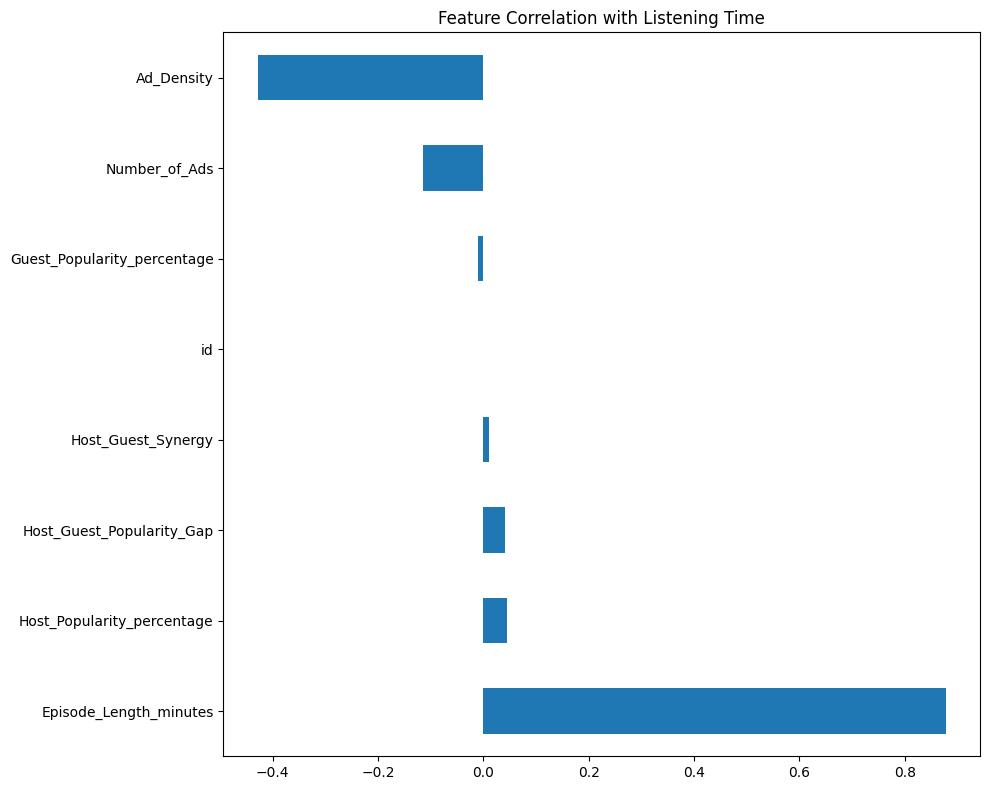

In [12]:
# Get categorical columns
cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
train_encoded = train[cols]

# Calculate correlation with target variable
correlation = train_encoded.corr(method='spearman')['Listening_Time_minutes'].sort_values(ascending=False)
correlation = correlation.drop('Listening_Time_minutes')  # Remove self-correlation

# Plot correlation with target
plt.figure(figsize=(10, 8))
correlation.plot(kind='barh')  # Changed to horizontal bars
plt.title('Feature Correlation with Listening Time')
plt.tight_layout()
plt.show()

# Tree-Based Feature Importance

In [13]:
train_encoded = train.drop(columns=['Episode_Title', 'Podcast_Name', 'id'])

In [14]:
import xgboost as xgb



# Get categorical columns
categorical_cols = train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

# Create dummy variables for categorical features
train_encoded = pd.get_dummies(train_encoded, columns=categorical_cols)

# Prepare data (X = features, y = target)
X = train_encoded.drop('Listening_Time_minutes', axis=1)
y = train_encoded['Listening_Time_minutes']

# Fit XGBoost model
model = xgb.XGBRegressor(
    random_state=1862,
    missing=np.nan, 
    eval_metric='rmse',
    n_jobs=-1,
    gpu_id=0, 
    )
model.fit(X, y)


d:\repositorios_pessoais\podcast-listening-predictor\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:29:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, ...)

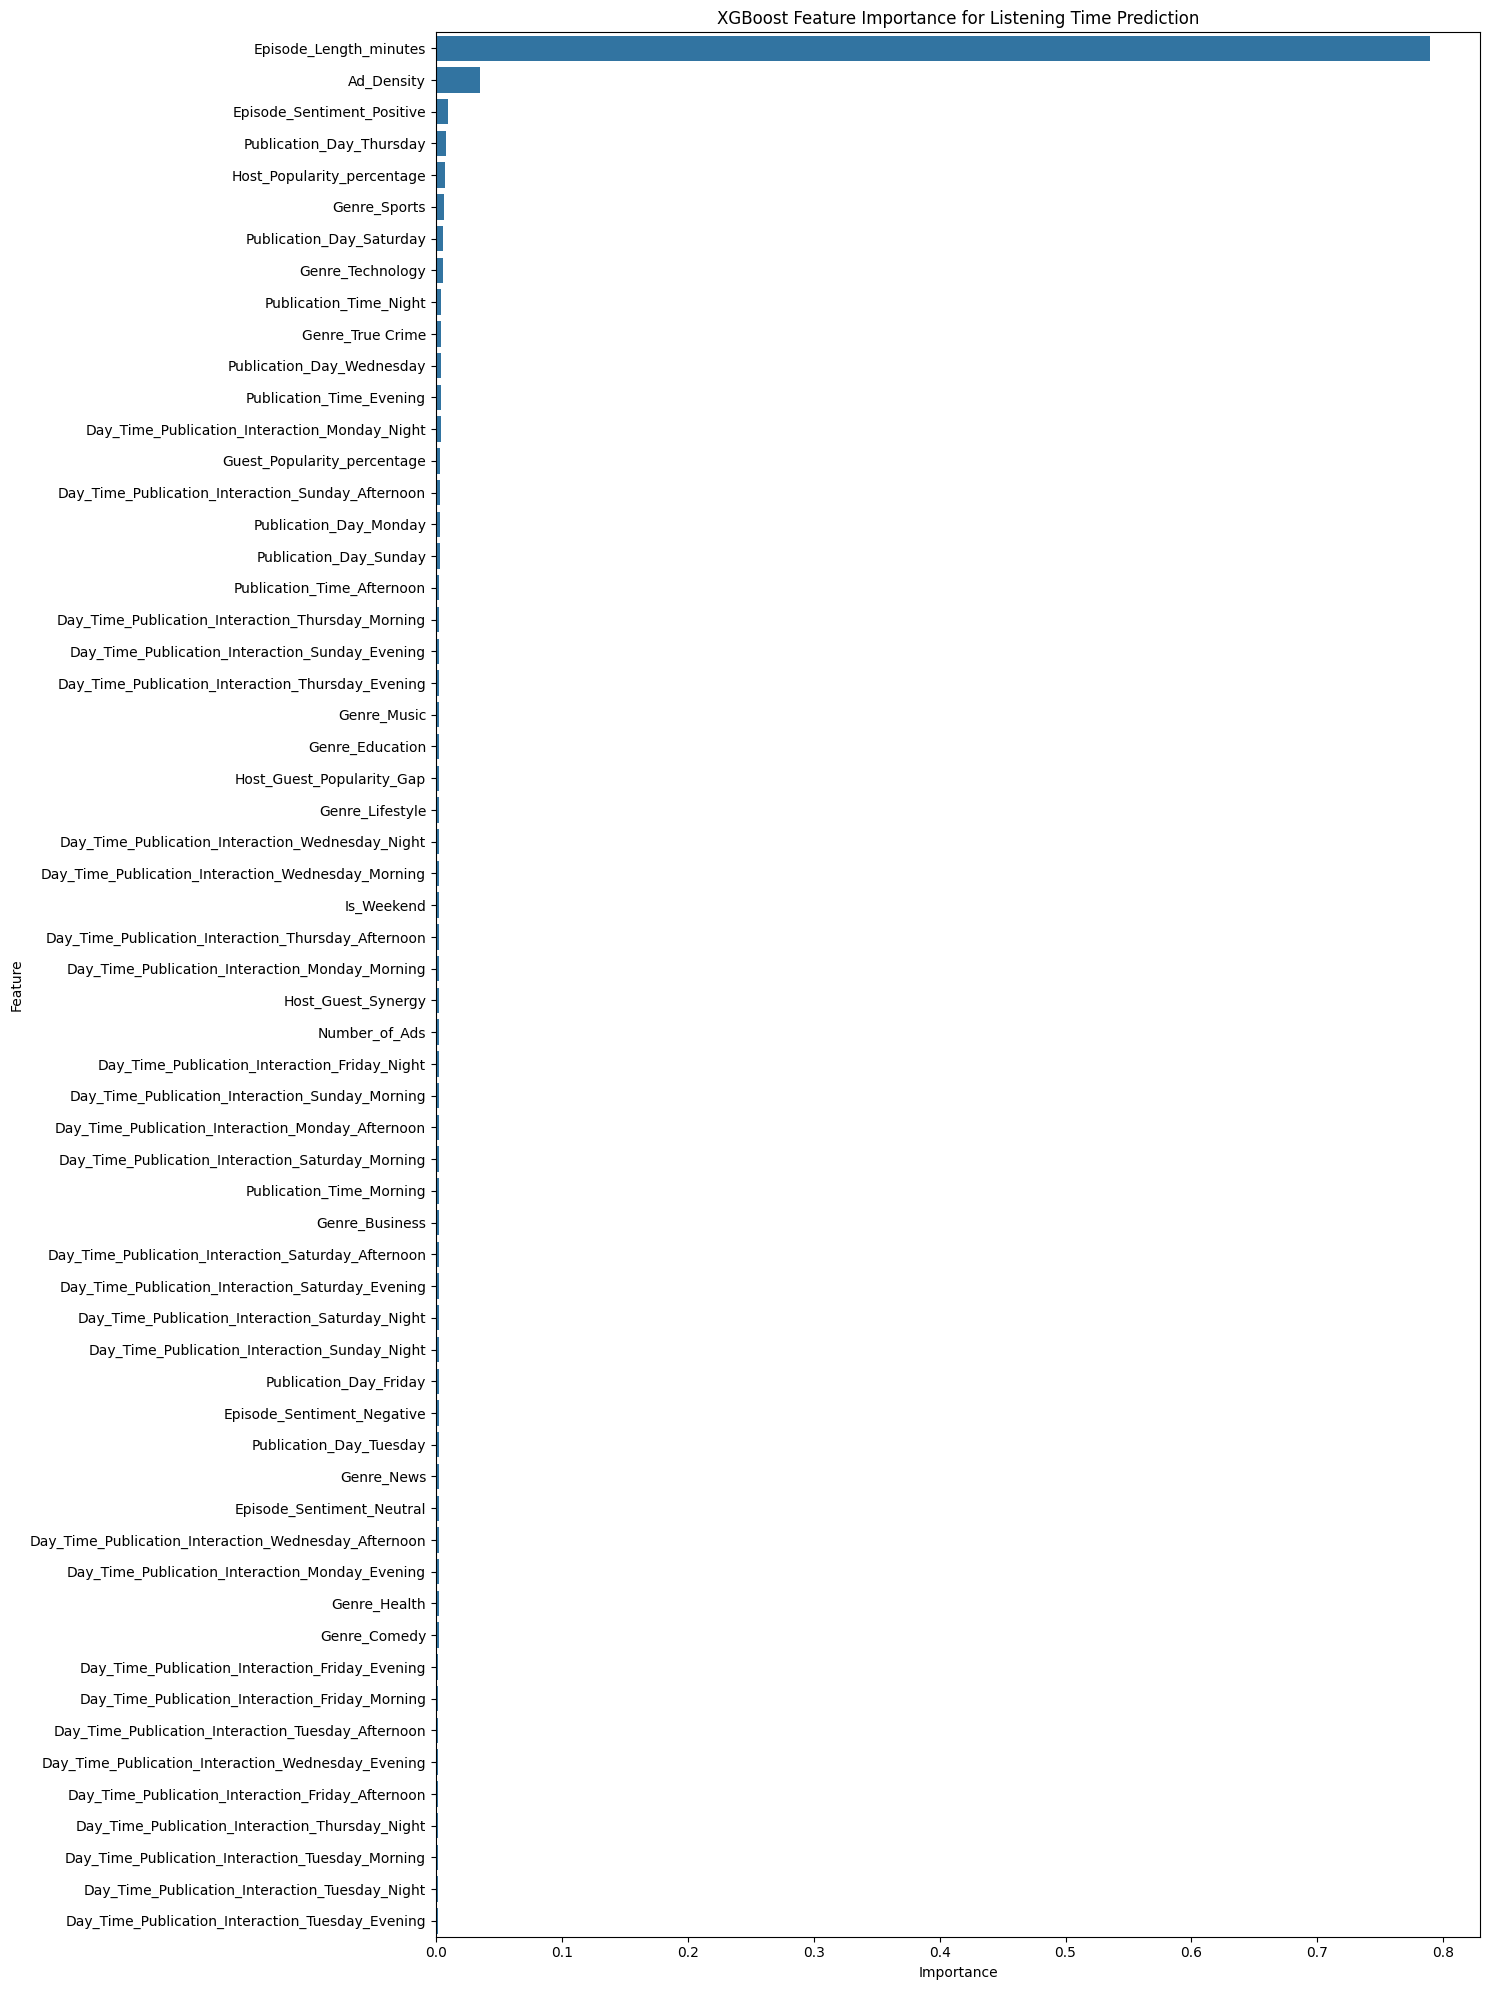

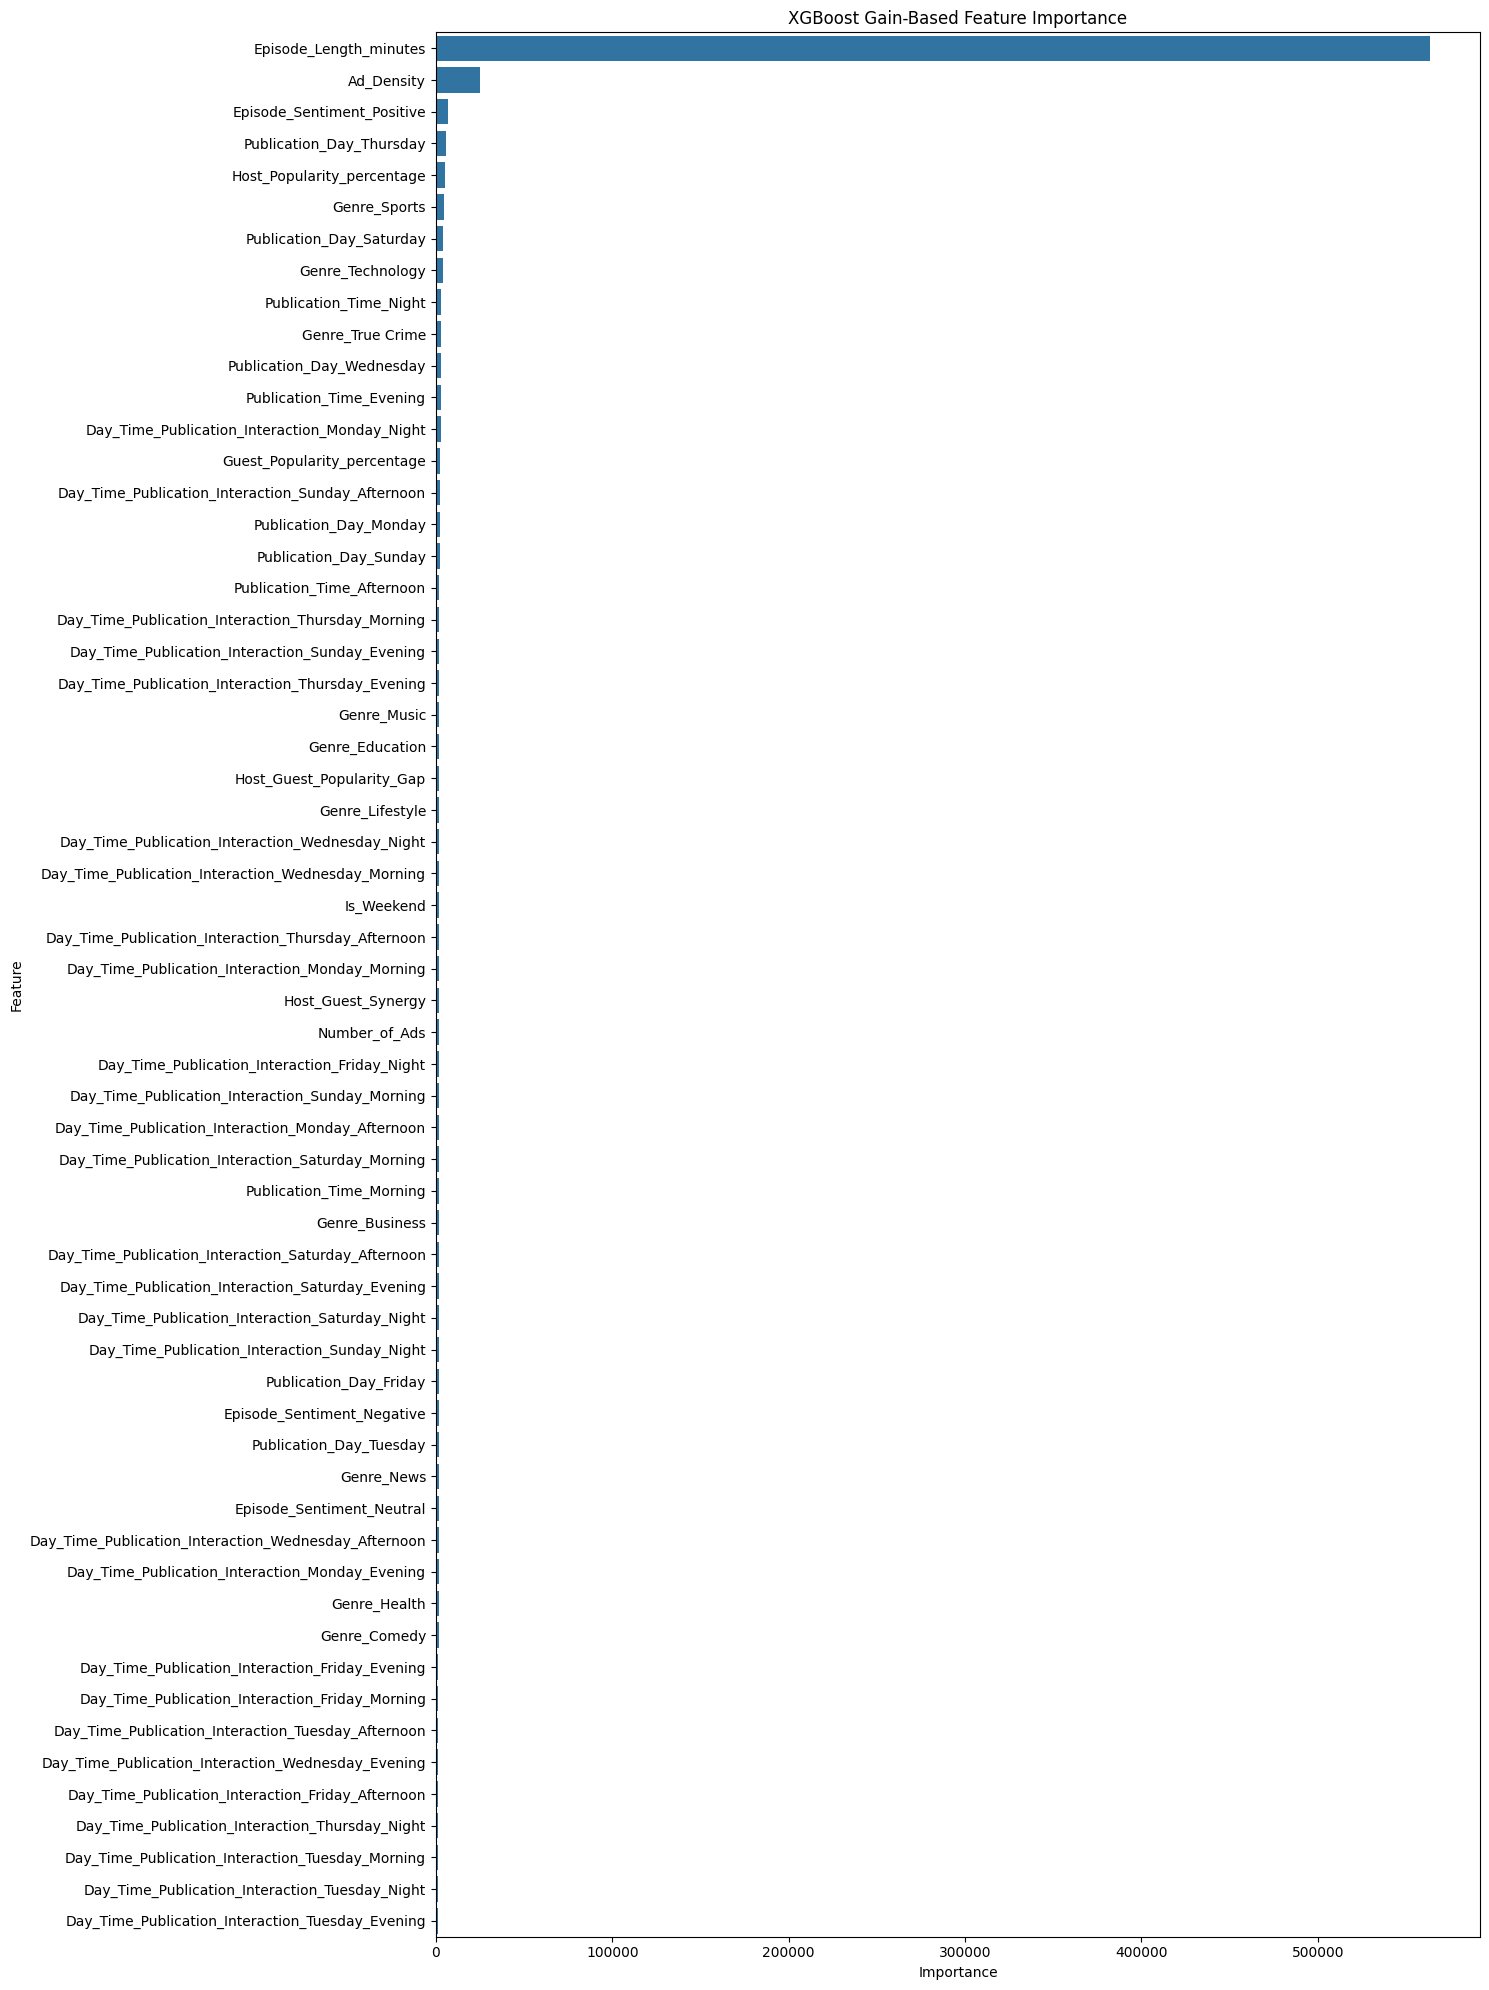

In [15]:

# Get feature importance
# Option 1: Using built-in feature importance (weight)
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(15, 20))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('XGBoost Feature Importance for Listening Time Prediction')
plt.tight_layout()
plt.show()

# Option 2: Get feature importance with gain (improvement in accuracy)
importance_gain = model.get_booster().get_score(importance_type='gain')
importance_gain = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Importance': list(importance_gain.values())
}).sort_values('Importance', ascending=False)

# Plot gain-based importance
plt.figure(figsize=(15, 20))
sns.barplot(x='Importance', y='Feature', data=importance_gain)
plt.title('XGBoost Gain-Based Feature Importance')
plt.tight_layout()
plt.show()

# Filter the original dataframes to only include these common important features

Number of common features in top 20: 20
Common features: ['Day_Time_Publication_Interaction_Monday_Night', 'Episode_Sentiment_Positive', 'Host_Popularity_percentage', 'Episode_Length_minutes', 'Publication_Time_Evening', 'Publication_Day_Thursday', 'Publication_Time_Afternoon', 'Publication_Time_Night', 'Genre_Technology', 'Guest_Popularity_percentage', 'Publication_Day_Sunday', 'Ad_Density', 'Genre_True Crime', 'Day_Time_Publication_Interaction_Thursday_Morning', 'Day_Time_Publication_Interaction_Sunday_Evening', 'Genre_Sports', 'Publication_Day_Wednesday', 'Day_Time_Publication_Interaction_Sunday_Afternoon', 'Publication_Day_Monday', 'Publication_Day_Saturday']


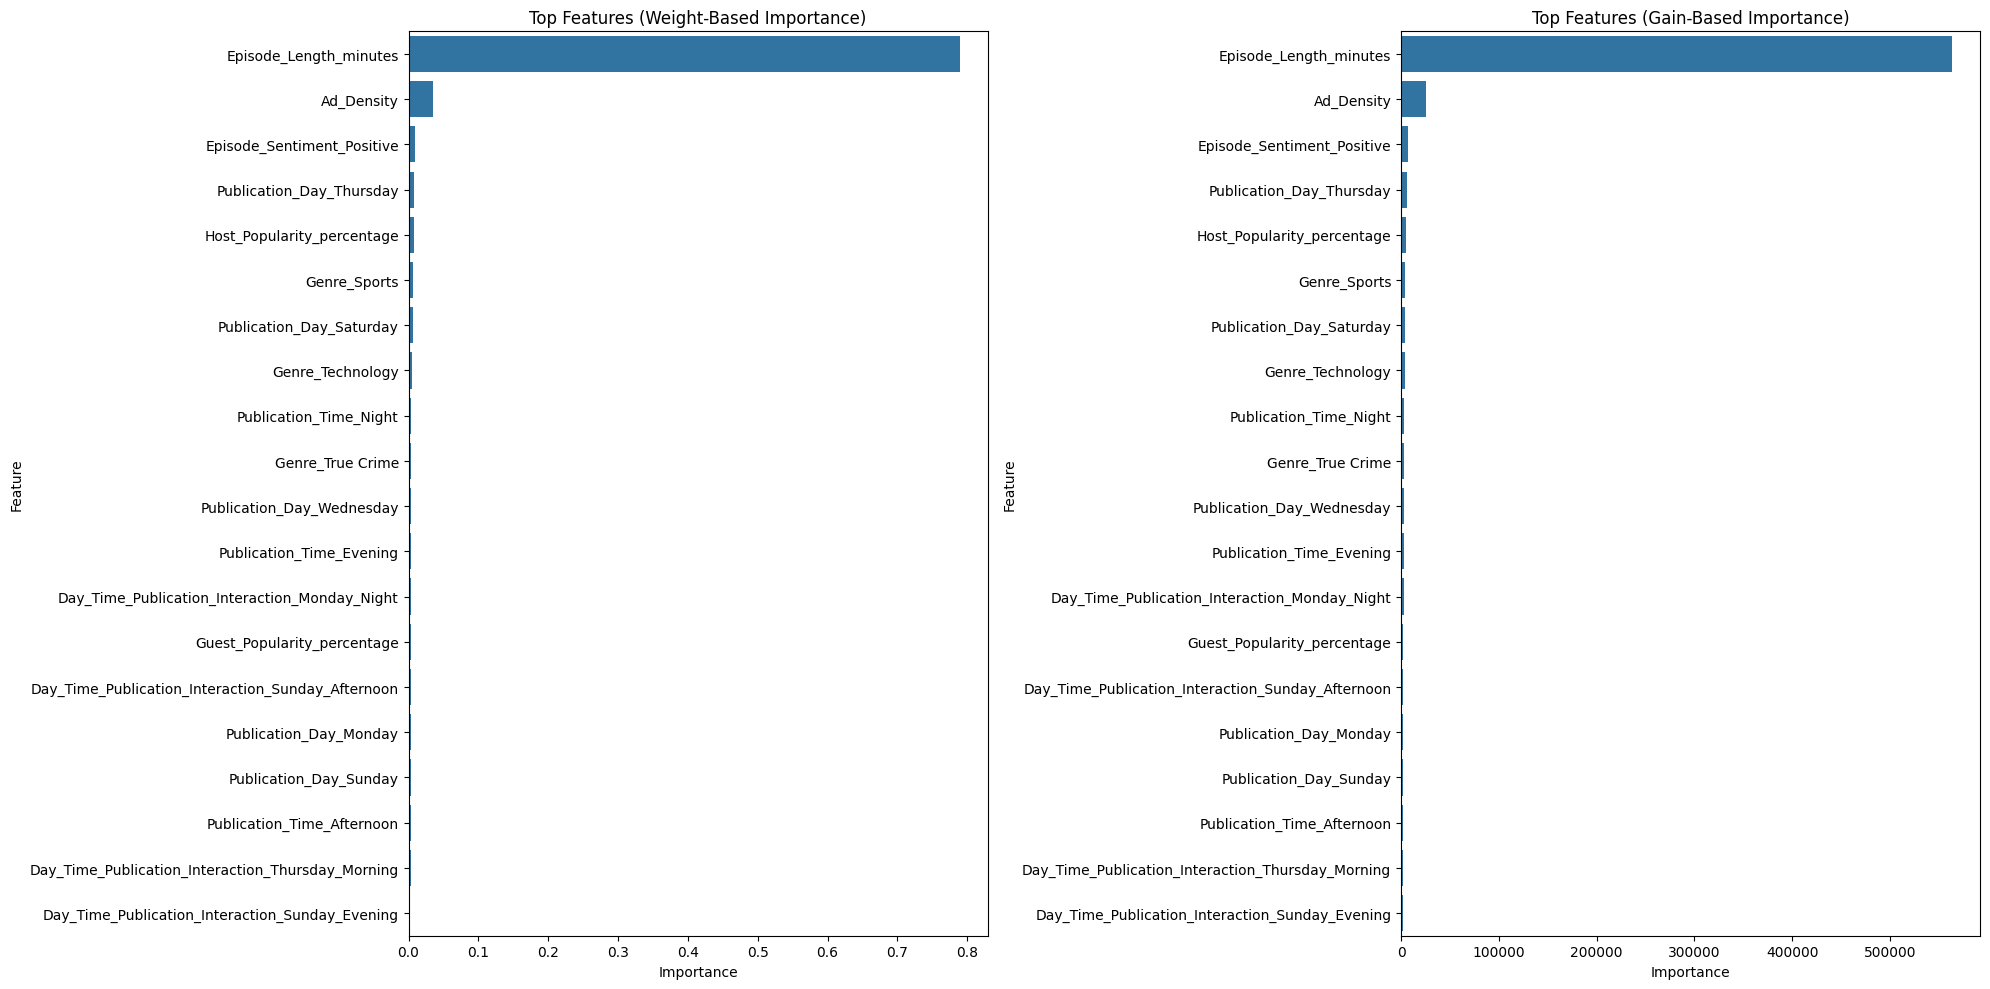

In [16]:
# Get top 20 features from each importance metric
top20_weight = importance.sort_values('Importance', ascending=False).head(20)['Feature'].tolist()
top20_gain = importance_gain.sort_values('Importance', ascending=False).head(20)['Feature'].tolist()

# Find common features between both top 20 lists
common_top_features = list(set(top20_weight) & set(top20_gain))
print(f"Number of common features in top 20: {len(common_top_features)}")
print(f"Common features: {common_top_features}")

# Filter the original dataframes to only include these common features
common_importance = importance[importance['Feature'].isin(common_top_features)].sort_values('Importance', ascending=False)
common_importance_gain = importance_gain[importance_gain['Feature'].isin(common_top_features)].sort_values('Importance', ascending=False)

# Create a combined visualization of these common important features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Weight-based importance
sns.barplot(x='Importance', y='Feature', data=common_importance, ax=ax1)
ax1.set_title('Top Features (Weight-Based Importance)')

# Gain-based importance
sns.barplot(x='Importance', y='Feature', data=common_importance_gain, ax=ax2)
ax2.set_title('Top Features (Gain-Based Importance)')

plt.tight_layout()
plt.show()

# Create a combined DataFrame for clearer comparison
combined_importance = pd.DataFrame({
    'Feature': common_top_features,
    'Weight_Importance': [importance[importance['Feature'] == f]['Importance'].values[0] for f in common_top_features],
    'Gain_Importance': [importance_gain[importance_gain['Feature'] == f]['Importance'].values[0] for f in common_top_features]
})

# Normalize

# Model Training


## XGBoost

In [17]:

filter_features = combined_importance.Feature.tolist()
filter_features.append('Listening_Time_minutes')
train_encoded = train_encoded[filter_features]

# Get categorical columns
categorical_cols = train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

# Create dummy variables for categorical features
train_encoded = pd.get_dummies(train_encoded, columns=categorical_cols)

# Prepare data (X = features, y = target)
X = train_encoded.drop('Listening_Time_minutes', axis=1)
y = train_encoded['Listening_Time_minutes']

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1862)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    # For dataset with skewed listening time target
    'max_depth': [3, 4, 5, 6],              # Balance between complexity and overfitting
    # 'learning_rate': [0.05, 0.1, 0.2],       # Good balance for your dataset size
    'n_estimators': [100, 200, 300],         # Higher for large dataset
    
    # For handling mixed categorical and numerical features
    # 'min_child_weight': [3, 5, 7, 9, 11],       # Higher to handle missing values robustly
    # 'subsample': [0.8, 0.9, 1.0],            # Good for large dataset
    'colsample_bytree': [0.8, 0.9, 1.0],     # Handle many dummy variables from encoding
    
    # For regularization
    'gamma': [0.1, 0.2, 0.3],                # Moderate pruning for podcast feature relationships
    # 'reg_alpha': [0.001, 0.01, 0.1],          # L1 regularization for feature selection
    # 'reg_lambda': [1.0, 1.5, 2.0],           # Standard L2 regularization

}

# Create base model
xgb_model = xgb.XGBRegressor(
    random_state=1862,
    missing=np.nan,
    eval_metric='rmse',
    gpu_id=0,
    n_jobs=-1
)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error'
)

# Fit Grid Search
grid_search.fit(X, y)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {-grid_search.best_score_:.4f}")


In [ ]:

# Train final model with best parameters
best_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=1862,
    missing=np.nan,
    eval_metric='rmse',
    n_jobs=-1
)
best_model.fit(X, y)

In [ ]:
model = best_model

#Load the test data
test = pd.read_csv(r"data/test.csv")
sample_submission = pd.read_csv(r"data/sample_submission.csv")

# Preprocess test data exactly the same way as training data


# Fill missing values (use training data for medians)
test = fill_missing_by_podcast_median(test, 'Episode_Length_minutes', train)
test = fill_missing_by_podcast_median(test, 'Guest_Popularity_percentage', train)

# Create the same features you created for training data
# Example feature engineering (adjust based on your actual features)

test['Ad_Density'] = test['Number_of_Ads'] / test['Episode_Length_minutes'].replace(0, np.nan)
test['Is_Weekend'] = test['Publication_Day'].isin(['Saturday', 'Sunday']).astype(bool)
test['Host_Guest_Popularity_Gap'] = test['Host_Popularity_percentage'] - test['Guest_Popularity_percentage']
test['Host_Guest_Synergy'] = test['Host_Popularity_percentage'] * test['Guest_Popularity_percentage']
test['Day_Time_Publication_Interaction'] = test['Publication_Day'] + '_' + test['Publication_Time']

test = test.drop(columns=['Episode_Title', 'Podcast_Name'])

# Handle categorical features - use same encoding as training
# Get categorical columns
categorical_cols = test.select_dtypes(include=['object', 'category']).columns.tolist()

# Create dummy variables consistent with training data
test_encoded = pd.get_dummies(test, columns=categorical_cols)

# Make predictions
predictions = model.predict(test_encoded[X.columns])

# Create submission file
submission = pd.DataFrame({
    'id': test_encoded['id'],
    'Listening_Time_minutes': predictions
})

# Check for invalid values in predictions
print(f"Min prediction: {submission['Listening_Time_minutes'].min()}")
print(f"Max prediction: {submission['Listening_Time_minutes'].max()}")
print(f"Any NaN values: {submission['Listening_Time_minutes'].isna().sum()}")

# Save the submission file
submission.to_csv(r'data/submission_xgboost_gridsearch_after_first_try.csv', index=False)
print("Submission file created successfully!")

# 8. Verify the format matches the sample submission
print("\nVerifying submission format:")
print(f"Sample submission shape: {sample_submission.shape}")
print(f"Your submission shape: {submission.shape}")
assert submission.shape == sample_submission.shape, "Submission shape doesn't match sample!"
assert all(submission.columns == sample_submission.columns), "Column names don't match sample!"
print("Submission format looks correct!")

# submission_first_try.csv
- Score in train data: 13.0943
- Score in kaggle submission: 13.19384

# submission_xgboost_gridsearch_after_first_try
- Score in train data: 13.0537
- Score in kaggle submission: 13.17141

**This leaderboard is calculated with approximately 20% of the test data. The final results will be based on the other 80%, so the final standings may be different!**

## Simple Linear Regression

In [17]:
train_encoded = train.drop(columns=['Episode_Title', 'Podcast_Name', 'id'])


# Get categorical columns
categorical_cols = train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

# Create dummy variables for categorical features
train_encoded = pd.get_dummies(train_encoded, columns=categorical_cols)

filter_features = combined_importance.Feature.tolist()
filter_features.append('Listening_Time_minutes')
train_encoded = train_encoded[filter_features]

train_encoded = train_encoded.fillna(train_encoded.median())

# Prepare data (X = features, y = target)
X = train_encoded.drop('Listening_Time_minutes', axis=1)
y = train_encoded['Listening_Time_minutes']

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# 2. Separate numerical and categorical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['uint8']).columns  # dummy variables

# 3. Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 4. Fit linear regression
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [19]:
# Load test data
test = pd.read_csv("data/test.csv")

# Fill missing values (use training data for medians)
test = fill_missing_by_podcast_median(test, 'Episode_Length_minutes', train)
test = fill_missing_by_podcast_median(test, 'Guest_Popularity_percentage', train)

# Create the same features you created for training data
# Example feature engineering (adjust based on your actual features)

test['Ad_Density'] = test['Number_of_Ads'] / test['Episode_Length_minutes'].replace(0, np.nan)
test['Is_Weekend'] = test['Publication_Day'].isin(['Saturday', 'Sunday']).astype(bool)
test['Host_Guest_Popularity_Gap'] = test['Host_Popularity_percentage'] - test['Guest_Popularity_percentage']
test['Host_Guest_Synergy'] = test['Host_Popularity_percentage'] * test['Guest_Popularity_percentage']
test['Day_Time_Publication_Interaction'] = test['Publication_Day'] + '_' + test['Publication_Time']

test = test.drop(columns=['Episode_Title', 'Podcast_Name'])

# Handle categorical features - use same encoding as training
# Get categorical columns
categorical_cols = test.select_dtypes(include=['object', 'category']).columns.tolist()

# Create dummy variables consistent with training data
test_encoded = pd.get_dummies(test, columns=categorical_cols)

# Scale numerical features using the same scaler from training
test_encoded[numerical_cols] = scaler.transform(test_encoded[numerical_cols])

# Make predictions
test_predictions = model.predict(test_encoded[X.columns])

# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'Listening_Time_minutes': test_predictions
})

# Save submission file
submission.to_csv('data/submission_linear_regression_with_feat_impt.csv', index=False)

# Verify submission format
print("\nVerifying submission format:")
print(f"Number of predictions: {len(test_predictions)}")
print(f"Min prediction: {submission['Listening_Time_minutes'].min()}")
print(f"Max prediction: {submission['Listening_Time_minutes'].max()}")
print(f"Any NaN values: {submission['Listening_Time_minutes'].isna().sum()}")
assert submission.shape == sample_submission.shape, "Submission shape doesn't match sample!"
assert all(submission.columns == sample_submission.columns), "Column names don't match sample!"
print("Submission format looks correct!")


Verifying submission format:
Number of predictions: 250000
Min prediction: -3783.0445901274143
Max prediction: 58582771.39757641
Any NaN values: 0
Submission format looks correct!


# submission_linear_regression.csv
- Score in train data:
- Score in kaggle submission: 13.44347

# submission_linear_regression_with_feat_impt
- Score in train data: 13.0537
- Score in kaggle submission: 13.5864

**This leaderboard is calculated with approximately 20% of the test data. The final results will be based on the other 80%, so the final standings may be different!**